<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

สมาชิกกลุ่ม

นายศิวกร ภาสว่าง 6410451423

นางสาว เเพรวรุ้ง พุดชะวา 6410451253

นางสาว มารีน่า มิทซุย 6410450222

หมู่ 200

ชุดข้อมูล : Cat and Dog

ลิ้งค์ดาวน์โหลด: https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.17.1'

In [2]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [3]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


### Download Dataset

In [4]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

100%|██████████| 218M/218M [00:10<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tongpython/cat-and-dog/versions/1
Download Dataset Complete


## Prepossessing


In [5]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['training_set', 'test_set'], Files: 0
Path: ./dataset/training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset/training_set/training_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/training_set/training_set/dogs, Subdirectories: [], Files: 4006
Path: ./dataset/training_set/training_set/cats, Subdirectories: [], Files: 4001
Path: ./dataset/test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset/test_set/test_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/test_set/test_set/dogs, Subdirectories: [], Files: 1013
Path: ./dataset/test_set/test_set/cats, Subdirectories: [], Files: 1012


In [6]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [7]:
import cv2
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

def change_gray_images(images):
    gray_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_images.append(image)

    gray_images = np.array(gray_images)
    gray_images = gray_images[..., np.newaxis]
    # gray_images = np.repeat(gray_images[:, :, :, np.newaxis], 3, axis=3)  # Repeat across the 3rd axis
    return gray_images

In [8]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(50, 50),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(50, 50),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)
X_train_gray = change_gray_images(X_train)
X_test_gray = change_gray_images(X_test)
del train_dataset
del test_dataset

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8005, 54, 54, 3)
y_train shape: (8005,)
X_test shape: (2023, 54, 54, 3)
y_test shape: (2023,)


In [11]:
print(f"X_train_gray: {X_train_gray.shape}")
print(f"X_test_gray: {X_test_gray.shape}")
SHAPE = X_train_gray.shape[1:]
print(f"New Shape: {SHAPE}")

X_train_gray: (8005, 54, 54, 1)
X_test_gray: (2023, 54, 54, 1)
New Shape: (54, 54, 1)


In [12]:
noise_factor = 0.1
X_train_noisy = X_train_gray + noise_factor * tf.random.normal(shape=X_train_gray.shape)
X_test_noisy = X_test_gray + noise_factor * tf.random.normal(shape=X_test_gray.shape)

X_train_noisy = tf.clip_by_value(X_train_noisy, clip_value_min=0., clip_value_max=1.)
X_test_noisy = tf.clip_by_value(X_test_noisy, clip_value_min=0., clip_value_max=1.)

In [13]:
print(f"X train Noisy: {X_train_noisy.shape}")
print(f"X test Noisy: {X_test_noisy.shape}")

X train Noisy: (8005, 54, 54, 1)
X test Noisy: (2023, 54, 54, 1)


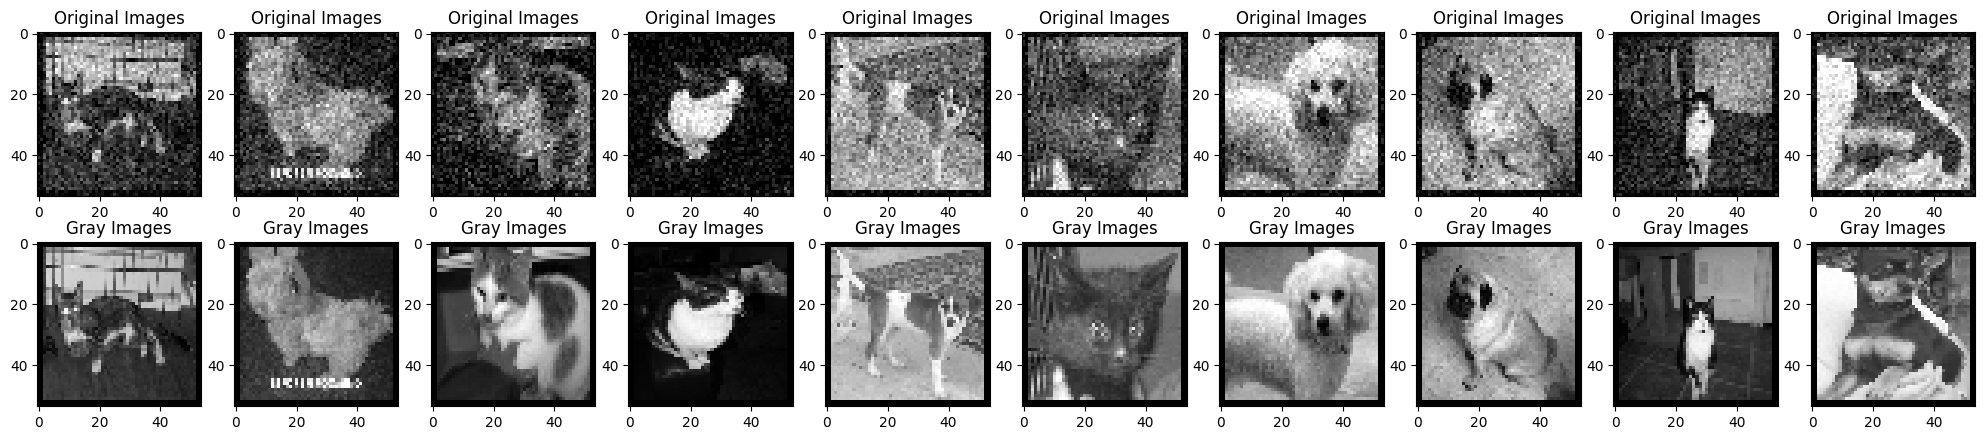

In [14]:
num_images = 10
fig = plt.figure(figsize=(25, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train_noisy[i], cmap='gray')
    plt.title("Original Images")

    plt.subplot(2, 10, i+1+num_images)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title("Gray Images")

### Create Model by using function API

#### Encoder Model

In [15]:
from tensorflow.keras import models, layers, losses, activations, optimizers
import tensorflow.keras.backend as K

LATENT_DIM = 2048

# Encoder Model
encoder_input = layers.Input(shape=SHAPE, name="Encoder_Input")

x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(encoder_input)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
# encoder_output = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, name='Encoder_Output')(x)
shape_before_flatten = K.int_shape(x)[1:]
# shape_before_flatten = K.int_shape(encoder_output)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(LATENT_DIM, activation=activations.relu, name="Encoder_Output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 54, 54, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 27, 27, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_Output (Dense)               │ (None, 2048)                │      95,553,536 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,591,136 (364.65 MB)

 Trainable params: 95,591,136 (364.65 MB)

 Non-trainable params: 0 (0.00 B)

#### Decoder Model

In [16]:
# Decoder Model
decoder_input = layers.Input(shape=(LATENT_DIM,), name="Decoder_Input")
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy(), activation=activations.relu)(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)

# decoder_input = layers.Input(shape=shape_before_flatten, name="Decoder_Input")

x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
# x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(decoder_input)
x = layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(x)

decoder_output = layers.Conv2D(filters=SHAPE[-1], kernel_size=(3, 3), padding='same', activation=activations.sigmoid, name="Decoder_Output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder_Input (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 46656)               │      95,598,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 27, 27, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 27, 27, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 27, 27, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 54, 54, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Output (Conv2D)              │ (None, 54, 54, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,672,609 (364.96 MB)

 Trainable params: 95,672,609 (364.96 MB)

 Non-trainable params: 0 (0.00 B)

#### Autoencoder Model

In [17]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 54, 54, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 27, 27, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_Output (Dense)               │ (None, 2048)                │      95,553,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 54, 54, 1)           │      95,672,609 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 191,263,745 (729.61 MB)

 Trainable params: 191,263,745 (729.61 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
EPOCH = 50
BATCH_SIZE = 100

autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss=losses.MeanSquaredError)
history = autoencoder.fit(X_train_noisy, X_train_gray, epochs=EPOCH, validation_data=(X_test_noisy, X_test_gray), batch_size=BATCH_SIZE)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 190ms/step - loss: 0.0669 - val_loss: 0.0361
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - loss: 0.0279 - val_loss: 0.0183
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0168 - val_loss: 0.0146
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 0.0136 - val_loss: 0.0123
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.0118 - val_loss: 0.0139
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 0.0116 - val_loss: 0.0106
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0084 - val_loss: 0.0091
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 0.0082 - val_loss: 0.0089
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 102m

In [19]:
prediction = autoencoder.predict(X_test_noisy)

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


Prediction results

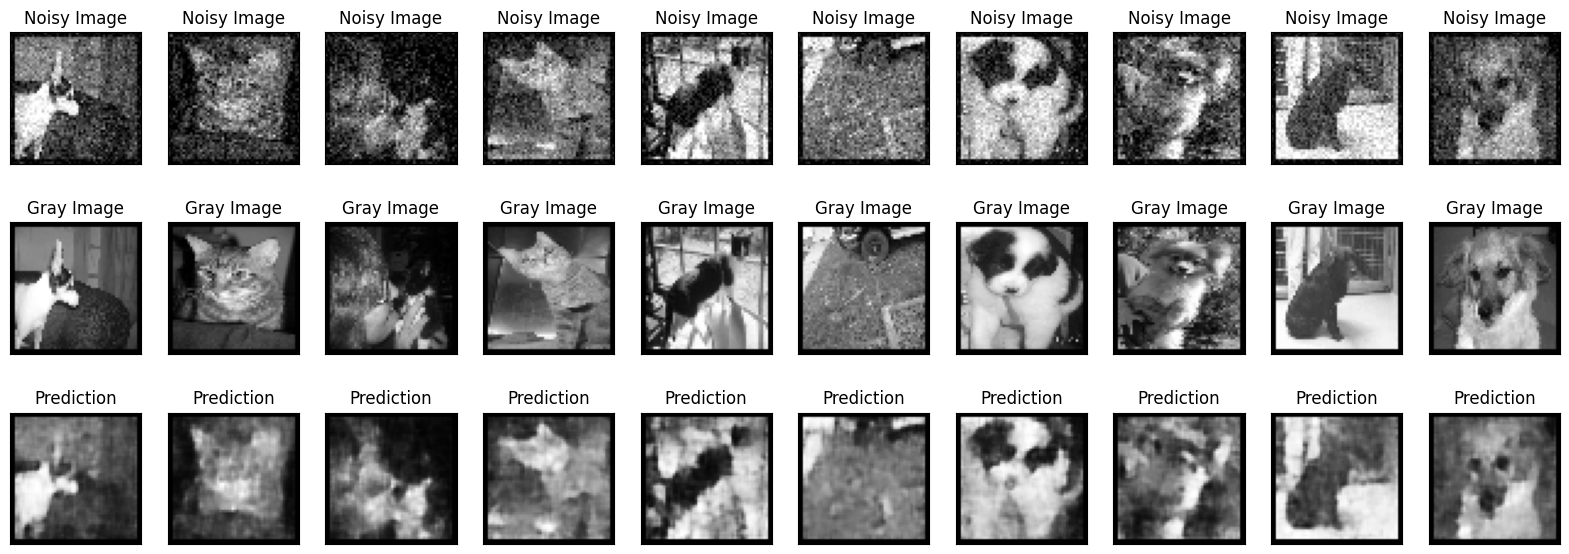

In [20]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i], cmap='gray')
    plt.title("Noisy Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test_gray[i], cmap='gray')
    plt.title("Gray Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(prediction[i], cmap='gray')
    plt.title("Prediction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## Visualization


In [21]:
encoder_imgs = encoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [22]:
x = encoder_imgs[:, 0]
y = encoder_imgs[:, 20]
z = encoder_imgs[:, 40]

Analyze latent space

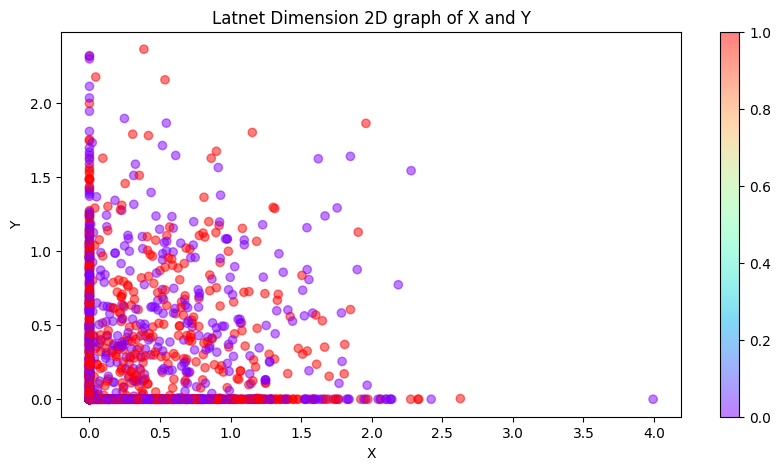

In [23]:
fig = plt.figure(figsize=(10, 5))

plt.title("Latnet Dimension 2D graph of X and Y")
plt.scatter(x, y, cmap="rainbow", c=y_test, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar()
plt.show()

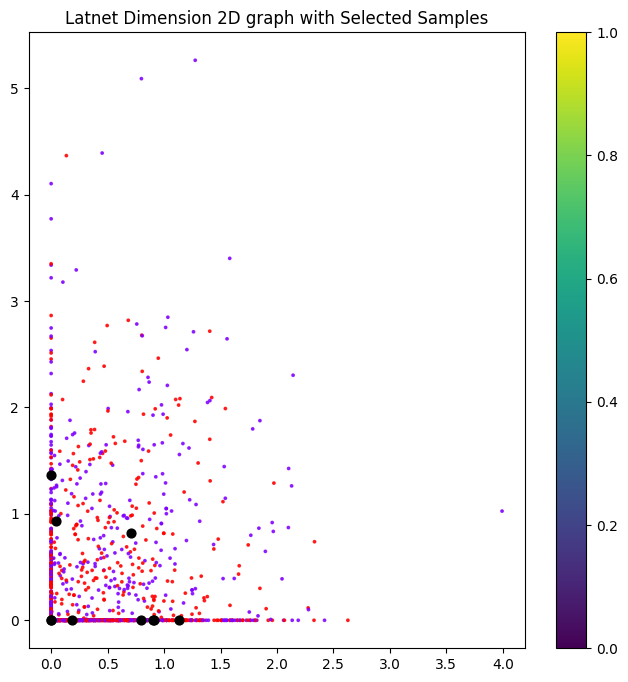

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


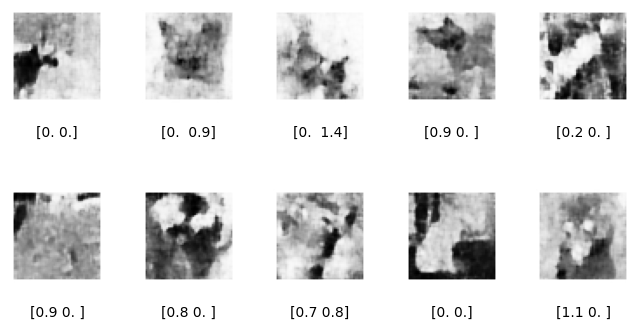

In [33]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(encoder_imgs[:, 0], encoder_imgs[:, 1], cmap="rainbow", c=y_test, alpha=0.8, s=3)
sample = encoder_imgs[:10]
plt.scatter(sample[:, 0], sample[:, 1], c="#000000", alpha=1, s=40)
plt.title("Latnet Dimension 2D graph with Selected Samples")
plt.colorbar()
plt.show()

grid_width, grid_height = 5, 2
reconstructions = autoencoder.predict(X_test_noisy[:grid_width * grid_height])

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(sample[i, 0:2], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap="Greys")
plt.show()


Text(0.5, 0, '$Z$')

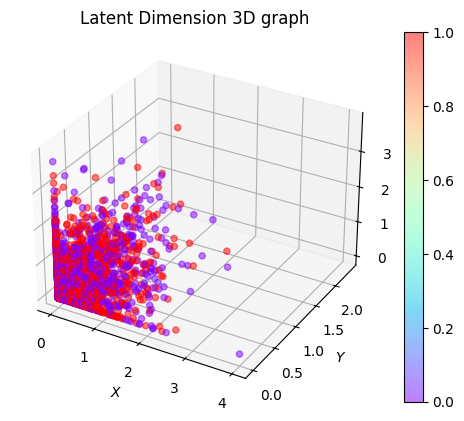

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
p = ax.scatter(x, y, z, alpha=0.5, c=y_test, cmap='rainbow')
plt.title("Latent Dimension 3D graph")
fig.colorbar(p)
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_zlabel("$Z$")

Analyze loss values

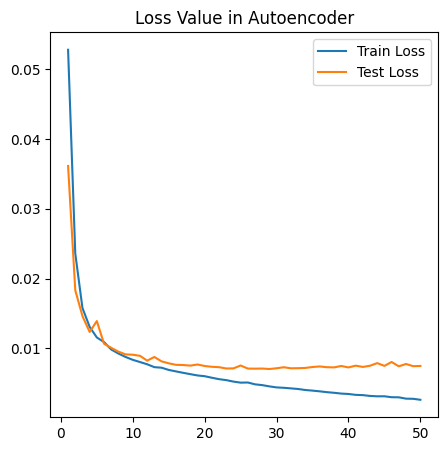

In [26]:
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']
fig = plt.figure(figsize=(5, 5))
plt.plot([i for i in range(1, 51)], loss_list, label='Train Loss')
plt.plot([i for i in range(1, 51)], val_loss_list, label='Test Loss')
plt.title("Loss Value in Autoencoder")
plt.legend()
plt.show()

### Member participation

ศิวกร รับผิดชอบ

- สร้าง autoencoder ทั้ง encoder และ decoder model

- สร้าง latent space 2 กราฟ ได้แก่ กราฟ 2 แกน และ กราฟ 3 แกน

- สร้าง loss values กราฟ แต่ละ epoch

มารีน่า รับผิดชอบ

- ทำ data prepossessing

- ช่วย ศิวกร ปรับจูนพารามิเตอร์ต่าง ๆ ของโมเดล

- สร้าง latent space 1 กราฟ ได้แก่ กราฟ 2 แกนที่สุ่มตัวอย่าง

- ทำ markdown

แพรวรุ้ง รับผิดชอบ

- ประสานงาน

- ช่วย มารีน่า ทำ data prepossessing

### AI disclosure

ใช้เครื่องมือปัญญาประดิษฐ์ คือ แชท GPT

ศิวกร

- ใช้หาเป้าหมายของ autoencoder ว่าคืออะไร

- ตรวจสอบแล้ว

มารีน่า

- ใช้อธิบายศัพท์เฉพาะ และค่าพาริมิเตอร์ที่ยังไม่เข้าใจ เช่น MeanSquaredError/LATENT_DIM คือค่าอะไร

- ตรวจสอบแล้ว

แหล่งอ้างอิงที่ใช้เพิ่มเติม :

https://www.tensorflow.org/tutorials/generative/autoencoder

https://www.kaggle.com/code/theblackmamba31/**autoencoder**-grayscale-to-color-image/notebook